In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout
#import mysql.connector as mariadb
import pymysql as mariadb


In [2]:
import gmres_display

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
def database_generator(cursor, data, n = None, show_progress = True):

    cursor.execute("SELECT COUNT(*) from Experiment")
    if not n:
        n_rows = cursor.fetchone()[0]
    else:
        n_rows = n
    c_rows = 0
    
    request = "SELECT"
    first = True
    for key in data:
        if not first:
            request += ","
        else:
            first = False
        request += " "
        if key == "faults":
            request += "fault_i, fault_k, fault_f, fault_bit, fault_reg"
        else:
            request += key
    request += " FROM Experiment"
    
    first = True
    for key in data:
        if data[key]:
            if first:
                first = False
                request += " WHERE "
            else:
                request += " AND "
            if key == "faults":
                key = "fault_i"
            request += key + " = " + str(data[key])
        
    
    print request    
    cursor.execute(request)
    row = cursor.fetchone()
    while row is not None:
        c_row = {}
        k = 0
        for key in data:
            if key == "faults":
                fault = {}
                fault["loc"] = {"i":row[k], "j":0, "k":row[k+1]}
                fault["timer"] = row[k+2]
                fault["bit"] = row[k+3]
                fault["register"] = row[k+4]
                c_row["faults"] = [fault] #TODO
                k += 4
            elif key == "l" or key == "m":
                c_row[key] = int(row[k])
            elif key == "residuals" or key == "true_residuals":
                c_row[key] = np.fromstring(row[k])
            else:
                c_row[key] = row[k]
            k += 1
        c_rows += 1
        if show_progress:
            new_progress = (100 * c_rows) / n_rows
            stdout.write("\r%d %c " % (new_progress, '%'))
            stdout.flush()
        yield c_row
        if (c_rows == n):
            break
        row = cursor.fetchone()
    

In [5]:
mariadb_connection = mariadb.connect(user='resilience', 
                                     #password='resilience_password', 
                                     passwd='resilience_password',
                                     host='192.168.1.48',
                                     database='gmres')
cursor = mariadb_connection.cursor()

SELECT A, residual, true_residual, fault_i, fault_k, fault_f, fault_bit, fault_reg, residuals, true_residuals, l FROM Experiment WHERE A = 'Rommes/S40PI_n'
10 % Rommes/S40PI_n
[{'loc': {'i': 1, 'k': 0, 'j': 0}, 'bit': 1, 'register': 3, 'timer': 14}]


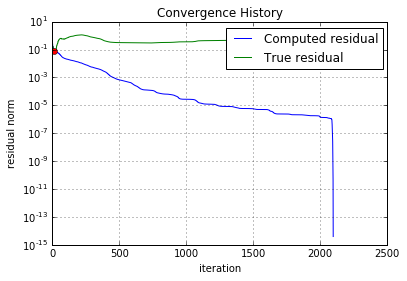

20 % Rommes/S40PI_n
[{'loc': {'i': 3, 'k': 4, 'j': 0}, 'bit': 5, 'register': 1, 'timer': 1819}]


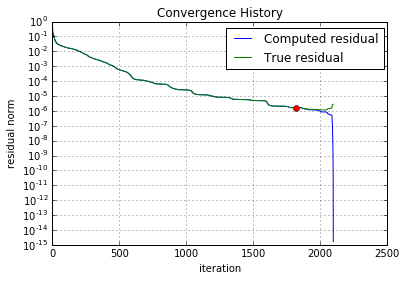

30 % Rommes/S40PI_n
[{'loc': {'i': 4, 'k': 3, 'j': 0}, 'bit': 30, 'register': 2, 'timer': 771}]


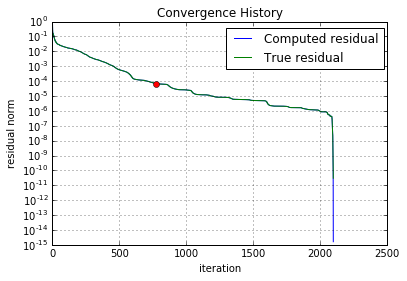

40 % Rommes/S40PI_n
[{'loc': {'i': 4, 'k': 5, 'j': 0}, 'bit': 34, 'register': 3, 'timer': 1601}]


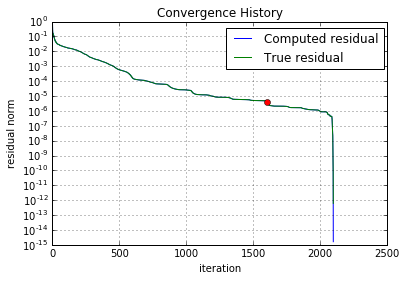

50 % Rommes/S40PI_n
[{'loc': {'i': 5, 'k': 2150, 'j': 0}, 'bit': 43, 'register': 1, 'timer': 482}]


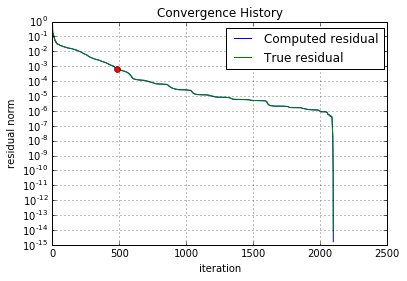

60 % Rommes/S40PI_n
[{'loc': {'i': 9, 'k': 10, 'j': 0}, 'bit': 44, 'register': 3, 'timer': 674}]


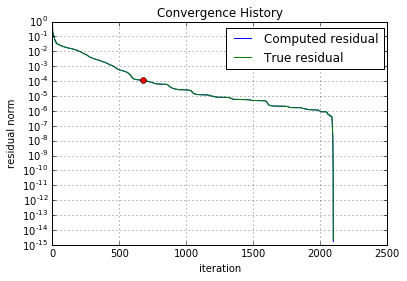

70 % Rommes/S40PI_n
[{'loc': {'i': 20, 'k': 21, 'j': 0}, 'bit': 40, 'register': 3, 'timer': 1914}]


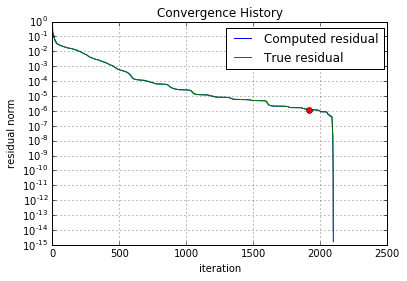

80 % Rommes/S40PI_n
[{'loc': {'i': 26, 'k': 27, 'j': 0}, 'bit': 4, 'register': 3, 'timer': 1675}]


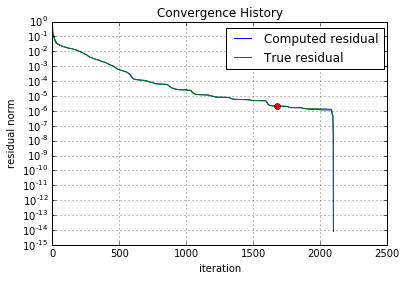

90 % Rommes/S40PI_n
[{'loc': {'i': 27, 'k': 26, 'j': 0}, 'bit': 31, 'register': 3, 'timer': 92}]


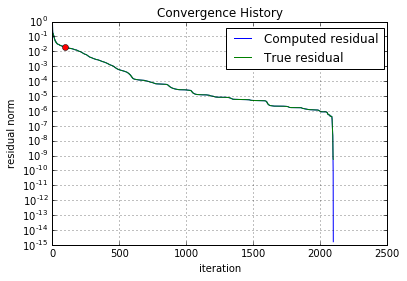

100 % Rommes/S40PI_n
[{'loc': {'i': 29, 'k': 29, 'j': 0}, 'bit': 52, 'register': 1, 'timer': 1078}]


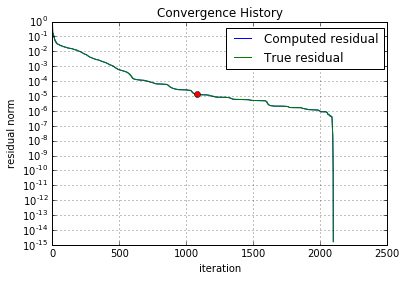

In [6]:
for d in database_generator(cursor, {"A":"'Rommes/S40PI_n'", "residual":None, "residuals":None, "true_residual":None, "true_residuals": None, "faults":None, "l":None}, 10):
    print d["A"]
    print d["faults"]
    gmres_display.convergence_history(d, true_residual = True, fault = True)
    plt.show()

SELECT A, fault_i, fault_k, fault_f, fault_bit, fault_reg, l, residuals, tol, true_residuals, m, residual, true_residual FROM Experiment
17 % 

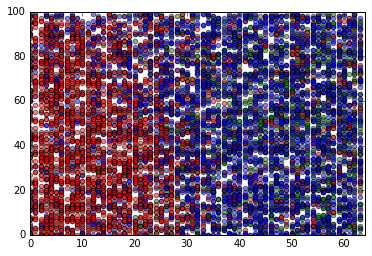

In [7]:
for d in database_generator(cursor, {"A":None, "m":None, "tol":None, "residual":None, "residuals":None, "true_residual":None, "true_residuals": None, "faults":None, "l":None}, 10000):
    cursor2 = mariadb_connection.cursor()
    cursor2.execute("SELECT MIN(l) FROM Experiment WHERE A = '" + d["A"] + "'")
    L = cursor2.fetchone()[0]
    
    if d["true_residual"] < 100 * d["tol"]:
        if L < d["l"]:
            c = "blue"
        else:
            c = "green"
    else:
        c = "red"
    
    plt.scatter(d["faults"][0]["bit"], (100*d["faults"][0]["timer" ]) / L, alpha = 0.5, c = c)
    plt.xlim(0, 64)
    plt.ylim(0, 100)

In [8]:
cursor2 = mariadb_connection.cursor()
cursor2.execute("SELECT A, count(*) FROM Experiment GROUP BY A")
for row in cursor2:
    print row[0], row[1]

Bai/bwm2000 995
Bai/qh768 1243
Bai/rdb800l 1001
Brethour/coater1 221
HB/impcol_a 1000
HB/mcfe 996
Morandini/rotor2 432
Rajat/rajat12 1597
Rommes/S40PI_n 1049


In [9]:
mariadb_connection.close()